# Laboratorium 6
## Rozwiazywanie układów równan liniowych
Natalia Brzozowska

***
### Zadanie 1 Metoda Gaussa-Jordana
Napisz i sprawdz funkcje rozwiazujaca układ równan liniowych n × n metoda Gaussa-
Jordana. Dla rozmiarów macierzy współczynników wiekszych niz 500 × 500 porównaj
czasy działania zaimplementowanej funkcji z czasami uzyskanymi dla wybranych funkcji
bibliotecznych.

***
Implementuję metodę Gaussa-Jordana, którą wykorzystam w celu rozwiązywaniu układów równań liniowych $ax=b$.<br>
W tym celu najpierw szukam maksymalnego elementu w każdym wierszu i dokładam go do tablicy s największych elementów. Następnie szukam odpowiedniego wiersza - pivota. Gdy zostanie znaleziony wiersz ten jest zamieniany z wierszem o indeksie k w macierzy l. Kolejnym krokiem jest obliczenie korzystając ze wzoru: $a_{ij} = a_{ij} - (\frac{a_{ik}}{a_{kk}}a_{kj}$ dla $k<=j<=n$, gdzie n jest roziarem macierzy.<br>
teraz pozostaje tylko obliczyć macierz wynikową. W tym celu korzystam z zależności $b_{li}=b_{li}-a_{lik}b_{lk}$ obliczając macierz b ($ax=b$). Następnie tworzę tablicę wynikową xs, do której później dodaję wartości wg. wzoru $x_{n}=\frac{b_{ln}}{a_{l_{n}n}}$. Ostatnim krokiem jest obliczenie $x_{i}=\frac{1}{a_{l_{i}i}}(b_{li} - \sum_{j=i+1} a_{l_{i}j}x_{j}$.

In [2994]:
import numpy as np
import time
import scipy.linalg

In [2995]:
def Gauss_Jordan_method(matrix, results):
    n = len(matrix)
    l=[0]*n
    s=[0]*n
    for i in range(n):
        l[i]=i
        mel=0
        for j in range(n):
            mel = max(mel,abs(matrix[i][j]))
        s[i]=mel
    for k in range(n):
        mrow = 0
        for i in range(k,n):
            r = abs(matrix[l[i]][k]/s[l[i]])
            if r>mrow :
                mrow=r
                j=i
        t=l[k]
        l[k]=l[j]
        l[j]=t
        for i in range(k+1,n):
            di = matrix[l[i]][k]/matrix[l[k]][k]
            matrix[l[i]][k] = di
            for j in range(k+1,n):
                matrix[l[i]][j] = matrix[l[i]][j] - di*matrix[l[k]][j]
    
    for k in range(n):
        for i in range(k+1,n):
            results[l[i]]=results[l[i]] - matrix[l[i]][k]*results[l[k]]
    xs=[0]*n
    for i in range(n-1,-1,-1):
        xs[i] = results[l[i]]/matrix[l[i]][i]
        suma=results[l[i]]
        for j in range(i+1,n):
            suma=suma-matrix[l[i]][j]*xs[j]
        xs[i]=suma/matrix[l[i]][i]
    return xs

In [2996]:
A = [[1, 2, 3], 
    [4, 3, -1],
    [1, -1, 1]]
B = [14,7,2]

In [2997]:
R = np.linalg.solve(A,B)

In [2998]:
R2 = Gauss_Jordan_method(A,B)

In [2999]:
print(np.allclose(R,R2))

True


Dla przykładowych macierzy A i B obliczam rozwiązanie przy pomocy zaimplementowanej metody, jak również korzystając z biblioteki numpy. Otrzymane wyniki porównuję funkcją numpy.allclose(), która zwróciła wartość true - zatem wyniki są zgodne. Co za tym idzie zaimplementowana funkcja oblicza poprawnie.
***

Napisałam funkcję porównującą czas rozwiązania układu równań liniowych. Porównuje ona trzy metody - zaimplementowaną wcześniej metodę Gaussa-Jordana, metodę biblioteki numpy.linalg.lstsq (metoda najmniejszych kwadratów) oraz metodę numpy.linalg.solve. Pomiar czasu przeprowadziłam dla macierzy o rozmiarze 600x600.

In [3000]:
def compare_time(A,B):
    start=time.time()
    np.linalg.solve(A,B)
    end=time.time()
    t_linalg = end-start
    
    start=time.time()
    np.linalg.lstsq(A,B,rcond=None)
    end=time.time()
    t_lstlq = end-start
    
    start=time.time()
    Gauss_Jordan_method(A,B)
    end=time.time()
    t_gauss = end-start
    
    print("czas trwania Gauss_Jordan_method(A,B):",t_gauss)
    print("czas trwania np.linalg.lstsq(A,B):",t_linalg)
    print("czas trwania np.linalg.solve(A,B):",t_lstlq)

In [3001]:
huge_random_matrix = np.random.rand(600, 600)
res = np.random.rand(600)
compare_time(huge_random_matrix,res)

czas trwania Gauss_Jordan_method(A,B): 81.39612770080566
czas trwania np.linalg.lstsq(A,B): 0.008963584899902344
czas trwania np.linalg.solve(A,B): 0.0937495231628418


***
Pomiary czasu działania funkcji pokazują, że najszybszą metodą rozwiązywania układów równań liniowych jest metoda najmniejszych kwadratów. Drugą, niewiele wolniejszą metodą jest ta zaimplementowana w funkcji numpy.linalg.solve(). Metoda Gaussa-Jordana okazała się być najwolniejsza i to o wiele bardziej niż dwie pozostałe. Redukcja wierszy, wielokrotne iteracje po elementach macierzy powodują, że metoda ta jest bardzo nisko wydajna.
***

### Zadanie 2 Faktoryzacja LU
**Napisz i sprawdź funkcje dokonujacą faktoryzacji A = LU macierzy A. Zastosuj częściowe
poszukiwanie elementu wiodacego oraz skalowanie.**

***
Napisałam program obliczający macierz trójkątną dolną L oraz macierz trójkątną górną G. Korzystam przy tym z metody Doolittle'a "udoskonalonej" przez częściowe poszukiwanie elementu wiodącego. To działanie pozwoli pozbyć się wady metody Doolittle'a, którą jest możliwość wystąpienia dzielenia przez zero, jeśli na przekątnej macierzy A pojawi się zero.<br>
Częściowe poszukiwanie elementu wiodącego polega na znalezieniu elementu o wartości największej (wartości bezwzględnej z tej wartości) w danej kolumnie i zamianie wiersza, w którym znajdował się ten element z numerem wiersza równym przeszukiwanej kolumnie. W ten sposób na przekątenj pojawią się największe elementy, przez co minializujemy możliwość dzielenia przez zero.<br><br>
Aby wyliczyć ustawienie wierszy macierzy A, tworzę macierz identycznościową p, w której będę zamieniała wiersze miejscami. Następnie pomnożę macierz p z macierzą A, otrzymując macierz do dalszych obliczeń.<br>
Korzystając z metody Doolittle'a wyliczam macierze U oraz L.

In [3002]:
def Doolittle_Crout_method(Mat):
    A=Mat
    n=len(A)
    l=np.zeros((n,n))
    u=np.zeros((n,n))
    p=np.identity(n)
                

    for y in range(0,n):
        maxi=abs(A[y][y])
        row=y
        
        for i in range(y+1,n):
            if (abs(A[i][y])> maxi) :
                maxi=abs(A[i][y])
                row=i
        p[[y,row]]= p[[row,y]]

        
        
    PA=p@A  

    A=np.array(A)
    for k in range(n):
        l[k][k]=1
        for j in range(k,n):
            suma=0
            for s in range(k):
                suma +=l[k][s]*u[s][j]
                
            u[k][j]=A[k][j]-suma
            
        for i in range(k,n):
            suma=0
            for s in range(k):
                suma +=l[i][s]*u[s][k]
                
            l[i][k]=(A[i][k]-suma)/u[k][k]
            
    return (l, u)

In [3053]:
random_matrix  = np.array(np.random.randint(10, size=(5, 5)))
random_matrix

array([[1, 4, 0, 5, 3],
       [0, 2, 0, 5, 2],
       [5, 0, 5, 8, 2],
       [0, 4, 0, 9, 9],
       [1, 2, 6, 0, 4]])

In [3054]:
L,U = Doolittle_Crout_method(random_matrix)
print("U\n",U)
print("L\n",L)
Ret = L@U
print(Ret)

U
 [[   1.     4.     0.     5.     3. ]
 [   0.     2.     0.     5.     2. ]
 [   0.     0.     5.    33.     7. ]
 [   0.     0.     0.    -1.     5. ]
 [   0.     0.     0.     0.  -203.4]]
L
 [[  1.    0.    0.    0.    0. ]
 [  0.    1.    0.    0.    0. ]
 [  5.  -10.    1.    0.    0. ]
 [  0.    2.    0.    1.    0. ]
 [  1.   -1.    1.2  39.6   1. ]]
[[1. 4. 0. 5. 3.]
 [0. 2. 0. 5. 2.]
 [5. 0. 5. 8. 2.]
 [0. 4. 0. 9. 9.]
 [1. 2. 6. 0. 4.]]


In [3055]:
#sprawdza poprawność danych wyjściowych i wejściowych
print("macierze wejsciowa i wyjsciowe są spójne -",np.allclose(random_matrix,Ret))

macierze wejsciowa i wyjsciowe są spójne - True


Otrzymane macierze U i L zgadzają się z oczekiwaniami - macierz L, na swojej przekątnej ma wartości 1, a wartości powyżej przekątnej są równe 0. Macierz U poniżej swojej przekątnej ma wszystkie wartości równe 0.<br><br>
Po pomnożeniu tych macierzy przez siebie otrzymujemy macierz A, co potwierdza prawdziwość równania $A=LU$.

***
### Zadanie 3 Analiza obwodu elektrycznego
**Napisz program, który:**<br>
   * **a) Wczytuje z pliku liste krawedzi grafu opisujacego obwód elektryczny. Wagi krawedzi okreslaja opór fragmentu obwodu miedzy dwoma wezłami. Wierzchołki grafu identyfikowane sa przez liczby naturalne.**<br>
   * **b) Wczytuje dodatkowo trójke liczb (s, t,E), przy czym para (s, t) wskazuje miedzy którymi wezłami sieci przyłozono siłe elektromotoryczna E. Opór wewnetrzny SEM mozna zaniedbac.**
***

Dane w pliku są zorganizowane następująco:
   * wierzchołek1 wierzchołek2 wartość<br>
   * wierzchołek1 wierzchołek2 wartość<br>
   * ...<br>
   * ...<br>
   * s t E

W ostatnim wierszu w pliku znajdują się: (s,t) - węzły między którymi przyłożono siłę elektromotoryczną oraz E - wartość tej siły.<br>
Przyjęłam, że prąd w obwodzie płynie od wierzchołka o mniejszym numerze do wierzchołka o większym numerze. NIe wpłynie to na wartość wyliczonych prądów - jedynie ich znak będzie przeciwny jeżeli prawda będzie sprzeczna z założeniem.

In [3006]:
import networkx as nx
import matplotlib.pyplot as plt
import typing

In [3007]:
def read_graph(file):
    G=nx.Graph()
    fp=open(file,"r")
    lines=fp.read().split('\n')
    graph = []
    for line in lines:
        edge = line.split(' ')
        graph.append(edge)
    i=0
    for i in range(len(graph)-1):
        edge=graph[i]
        G.add_node(int(edge[0]))
        G.add_edge(int(edge[0]),int(edge[1]), weight=int(edge[2]), current=0)
        i+=1
    return(G,graph)

Ta funkcja czyta graf z pliku, tworzy tabelę, do której wpisuje dane z pliku oraz tworzy graf.<br>
Poniższa funkcja rysuje graf, wraz z jego atrybutami - wagami krawęzi.

In [3008]:
def draw(G):
    pos =nx.spring_layout(G)
    plt.figure(figsize=(12,12))
    edges = G.edges(data='weight')
    labels = nx.get_edge_attributes(G,'weight')
    labels_form = {}
    for key, val in labels.items():
        labels_form[key] = "{0:.3f}".format(val)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels_form)
    nx.draw(G,pos) 
    plt.show()

Poniższy przykład przedstawia niewielki graf, ponieważ tak będę mogła łatwiej ręcznie sprawdzić poprawność obliczeń. Na krawędziach znajdują się wartości rezystancji danej gałęzi.

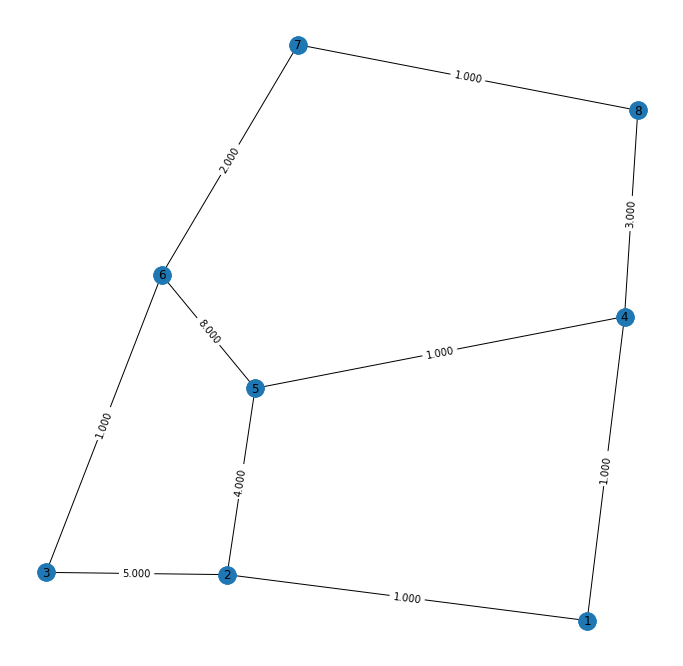

In [3056]:
G,graph = read_graph("obwod.txt")
draw(G)

Zmienna last będzie przechowywała wartości ostatniego wiersza pliku. Podstawowe własności grafu:

In [3010]:
N = np.array(G.nodes())
l= graph[len(G.edges())]
last=[]
for i in l:
    i=int(i)
    last.append(i)
print(last)
print("wierzchołki: ",N)
print("ilość krawędzi: ",len(G.edges()))
print("ilość wierzchołków: ",len(G.nodes()))

[4, 1, 30]
wierzchołki:  [1 2 3 6 5 4 7 8]
ilość krawędzi:  10
ilość wierzchołków:  8


***
* **c) Wykorzystujac prawa Kirchhoffa znajduje natezenia pradu w kazdej czesci obwodu i przedstawia je na rysunku w postaci grafu wazonego z etykietami.**
***

W przedstawionym rozwiązaniu za gałęzie obwodu uznaję krawędzie łączące wierzchołki, a za węzły wszystkie wierzchołki. Nie jest to w pełni zgodne z teorią obwodów, jednak nie powinno wpłynąć na poprawność rozwiązania.<br><br>
W teorii obwodów znajdują się dwie metody pozwalające obliczyć prądy gałęziowe. Są to: metoda oczkowa oraz metoda węzłowa, nazywana również metodą potencjałów węzłowych. Obie te metody wykorzystują prawa Kirchoffa. Żeby jednak móc porównać wynik jednej metody z metodą potencjałów węzłowych musze wykorzystać najpierw metodę oczkową.

**1. Metoda oczkowa**

Aby policzyć prąd płynący w gałęziach musimy skorzystać z drugiego prawa Kirchoffa dotyczącego oczek.Mówi ono o tym, że  w oczku niezależnym obwodu suma spadków napięć na wszytskich odbiornikach prądu musi być równa zeru. Czyli suma spadków napięc na oporach jest równa sumie sił elektromotorycznych w tym obwodzie.

W metodzie oczkowej należy najpierw znaleźć macierz incydencji oczkową B (a przynajmniej robiąc to, jest łatwiej). 
Tworzę więc macierz incydencji oczkową B, w taki sposów, że wierszom macierzy odpowiadają oczka, a kolumnom gałęzie.
Jeśli:
* $b_{ij} = 1$ jeśli gałąź j należy do oczka i oraz jej zwrot jest zgodny ze zwrotem obiegowym oczka
* $b_{ij} = -1$ jeśli gałąź j należy do oczka i oraz jej zwrot jest przeciwny do zwrotu obiegowego oczka
* $b_{ij} = 0$ jeśli gałąź j nie należy do oczka

Za zwrot obiegowy oczka uznałam zwrot tworzony poprzez przejście wierzchołków w każdym cyklu, zwróconych przez funkcję nx.cycle_basis(). 

In [3011]:
def findId(edges, tup):
    i =0
    revTup = (tup[1],tup[0])
    for edge in edges:
        if tup==edge or revTup==edge:
            return i
        i+=1
    return -1
        
def makeB(G):
    cycles = nx.cycle_basis(G)
    brow=np.zeros(len(G.edges()))
    edges = G.edges()
    B=[]
    for cycle in cycles:
        brow=np.zeros(len(G.edges()))
        for i in range(1,len(cycle)):
            if cycle[i-1]<cycle[i]:
                idd = findId(edges,(cycle[i-1],cycle[i]))
                brow[idd] = 1
            else:
                 brow[findId(edges,(cycle[i],cycle[i-1]))] = -1
                    
        if cycle[len(cycle)-1]<cycle[0]:
            brow[findId(edges,(cycle[0],cycle[len(cycle)-1]))] = 1
        else:
            brow[findId(edges,(cycle[len(cycle)-1],cycle[0]))] = -1
        
        B.append(brow)
    return np.array(B)

In [3012]:
B = makeB(G)
print(B)

[[ 0.  0.  0.  0.  0.  1.  1.  1. -1.  1.]
 [ 1. -1.  1.  0.  1.  0.  1.  0. -1.  1.]
 [ 1. -1.  0.  1.  0.  0.  0. -1.  0.  0.]]


Pomocnicza funkcja findId znajduje id aktualnie rozpatrywanej krawędzi, po to by w odpowiednim miejscu w tablicy umieścić dane dotyczące określonej krawędzi.<br><br>

Następnie utworzę macierz Z - macierz diagonalną impedancji(rezystancji) gałęzi. W tej macierzy na przekątnej znajdują się odpowiednie wartości rezystancji dotyczące danej gałęzi. Np. wartość impedancji gałęzi pierwszej znajdzie się w miejscu $z_{11}$.

In [3013]:
def makeZ(G):
    Z=[]
    zrow=np.zeros(len(G.edges()))
    edges = G.edges(data='weight')
    i=0
    for (u,v,weight) in edges:
        zrow=np.zeros(len(G.edges()))
        zrow[i]=weight
        i+=1
        Z.append(zrow)
    return np.array(Z)

In [3014]:
Z = makeZ(G)
print(Z)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 8. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Następnie tworzę macierz napięć źródłowych gałęzi. Przedstawia ona wartości napięcia na danych gałęziach. W przypadku tego zadania, jedynie w jednej komórce tabeli znajdzie się cyfra inna niż 0.

In [3015]:
def makeE(graph,G):
    edg_len = len(G.edges())
    I=np.zeros(edg_len)
    edges=G.edges(data='weight')
    j=0
    for (u,v,weight) in edges:
        if (u==(last[0]) and v==(last[1])) or (v==(last[0]) and u==(last[1])):
            I[j]=(int(last[2])/weight)
        j+=1
    return np.array(I)

In [3016]:
E = makeE(graph,G)
print(E)

[ 0. 30.  0.  0.  0.  0.  0.  0.  0.  0.]


Tak też się stało. Oznacza to, że napięcie przyłożono do drugiej krawędzi.<br><br>

Kolejnym krokiem będzie wyliczenie macierzy I - macierzy prądów gałęziowych. Skorzystam ze wzorów $BZB^{T}i_{on}=BE$, oraz $I=i_{on}B^{T}$. Wartości prądów zmienię na ich wartości bezwzględne, ponieważ interesuje nas wartość, a nie poprawa zaznaczonych wcześniej kierunków przepływu prądu.

In [3017]:
def solve(B,E,Z):
    ion,r1,r2,r3 = np.linalg.lstsq(B@Z@B.T,B@E,rcond=None)
    ir=B.T@ion
    Io = abs(ir)
    return Io

In [3018]:
Io = solve(B,E,Z)
print(Io)

[5.51785714 5.51785714 1.82142857 3.69642857 1.82142857 0.48214286
 1.33928571 4.17857143 1.33928571 1.33928571]


Odpowiednie wartości odpowiadają konkretnym gałęziom wskazywanym przez indeks tablicy. Jest to ten sam indeks elementu, który wyświetli się po wywołaniu funkcji G.edges().

Można teraz narysować badany graf, zastępując wagi krawędzi wartościami płynącego w nich prądu.

In [3019]:
def addCurrent(G, Result):
    NG=nx.Graph();
    i=0
    for edge in G.edges():
        NG.add_node((edge[0]))
        NG.add_edge((edge[0]),(edge[1]), weight=Result[i])
        i+=1
    return(NG)

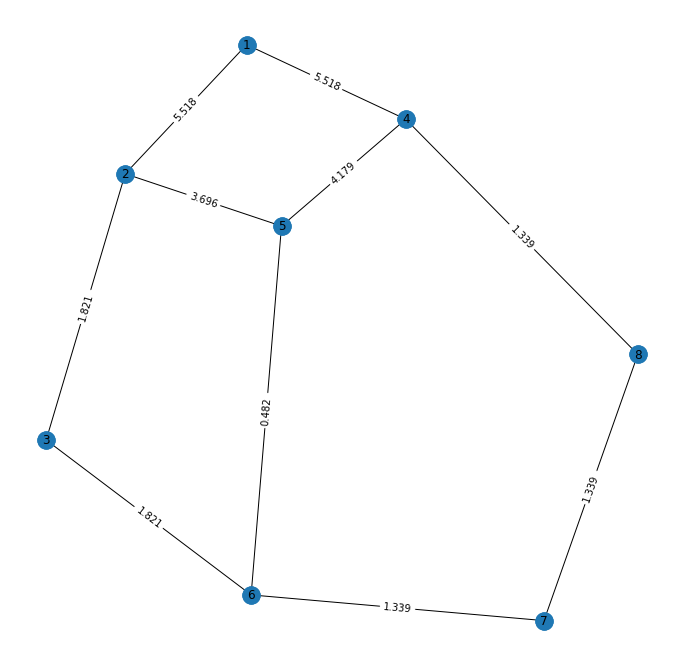

In [3020]:
NG = addCurrent(G,Io)
draw(NG)

***
* **e) Wykorzystujac metode potencjałów wezłowych zaimplementuj alternatywne rozwiazanie problemu.**
***

**2. Metoda węzłowa** <br><br>

Korzystając z macierzy strukturalnych i praw Kirchoffa oraz Ohma w postaci macierzowej wyliczam zadane wartości.
Tworzę macierz incydencji węzłową A, w taki sposów, że wierszom macierzy odpowiadają węzły obwodu, a kolumnom gałęzie.
Jeśli:
* $a_{ij} = 1$ jeśli gałąż j jest incydentna z węzłem i oraz ma zwrot od węzła
* $a_{ij} = -1$ jeśli gałąż j jest incydentna z węzłem i oraz ma zwrot do węzła
* $a_{ij} = 0$ jeśli gałąż j nie jest incydentna z węzłem 

In [3021]:
def makeA(G):
    nodes=np.array(G.nodes())
    edges=G.edges(data='weight')
    edg_len = len(G.edges())
    wsp=[]
    
    for i in range(len(G.nodes())):
        j=0
        one_curr=np.zeros(edg_len)
        if i<len(G):
            node=nodes[i]
            
            for (u,v,weight) in edges:
                if(np.all(u==node)):
                    one_curr[j]=-1
                    
                elif(np.all(v==node)):
                    one_curr[j]=1
                    
                else:
                     one_curr[j]=0
                
                j+=1
        wsp.append(one_curr)
        i+=1

    return np.array(wsp)

In [3022]:
Aa = makeA(G)
print(Aa)

[[-1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]]


Otrzymałam macierz, w której w każdej kolumnie suma cyfr jest równa 0. Wiersze w danej macierzy są liniowo zależne - każdy wiersz danej macierzy jest kombinacją liniową  pozostałych wierszy. Można zatem wykreślić dowolny wiersz, nie powodując utraty informacji o grafie.<br>
Skreślony wiersz będzie oznaczał wybrany węzeł odniesienia. Wybieram za punkt odniesienia wiersz zerowy.

In [3023]:
def chooseReferenceA(Aa,n):
    A=[]
    for i in range(len(Aa)):
        if i!=n:
            A.append(Aa[i])
    return np.array(A)

In [3024]:
A = chooseReferenceA(Aa,0)
print(A)
print(len(A))

[[ 1.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  1.  0. -1.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.]]
7


Tak oto otrzymałam macierz węzłową A.<br>

Następnie potrzebuję utworzyć macierz admitancji własnych i wzajemnych G, będącą macierzą kwadratową symetryczną. Admitancja jest odwrotnością rezystancji. Prostrzym (wg. mnie) sposobem na obliczenie tej macierzy jest obliczenie najpierw macierzy Gd - macierzy diagonalnej analogicznej do macierzy Z, jednak zawierającej admitację gałęzi, a nie ich impedancję. Będzie można wtedy skorzystać ze wzoru $G=AG_{d}A^{T}$.

In [3025]:
def makeGd(G):
    ar=[]
    zrow=np.zeros(len(G.edges()))
    edges = G.edges(data='weight')
    i=0
    for (u,v,weight) in edges:
        zrow=np.zeros(len(G.edges()))
        zrow[i]=1/weight
        i+=1
        ar.append(zrow)
    return np.array(ar)

In [3026]:
Gd=makeGd(G)
print(Gd)

[[1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.2        0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.25       0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.125
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.33333333 0.        ]
 [0.         0.         0.        

Tak otrzymałam macierz Gd. Macierz G powstanie w następnym kroku:

In [3027]:
def makeGc(A,Gd):
    Gc = A@(Gd@(A.T))
    return Gc

In [3028]:
Gc=makeGc(A,Gd)
print(Gc)

[[ 1.45       -0.2         0.         -0.25        0.          0.
   0.        ]
 [-0.2         1.2        -1.          0.          0.          0.
   0.        ]
 [ 0.         -1.          1.625      -0.125       0.         -0.5
   0.        ]
 [-0.25        0.         -0.125       1.375      -1.          0.
   0.        ]
 [ 0.          0.          0.         -1.          2.33333333  0.
  -0.33333333]
 [ 0.          0.         -0.5         0.          0.          1.5
  -1.        ]
 [ 0.          0.          0.          0.         -0.33333333 -1.
   1.33333333]]


Pozostaje już tylko obliczyć macierz prądów gałęziowch. W tym celu najpierw obliczę macierz napięć międzywęzłowych Up. Są to napięcia między węzłem odniesienia (węzeł 0), a pozostałymi węzłami liniowo niezależnymi. Do wyliczenia tej macierzy korzystam ze wzoru $U_{p}=G^{-1}AG_{d}E$.<br><br>
Nastęnie ze wzoru $U=A^{T}U_{p}$ wyliczę U - macierz napięć gałęziowych.

In [3029]:
def makeU(Gc,A,Gd,E):
    Up = np.linalg.inv(Gc)@(A@(Gd@E))
    U = A.T@Up
    return U

In [3030]:
U=makeU(Gc,A,Gd,E)
print(U)

[ 5.51785714 24.48214286  9.10714286 14.78571429  1.82142857  3.85714286
  2.67857143  4.17857143 -4.01785714  1.33928571]


Aby teraz otrzymać końcową macierz prądów gałęziowych Iw, skorzystam z prawa Ohma $I=UG$. W przypadku gałęzi do której przyłączona jest siła elektromotoryczna E, by obliczyć napięcie na niej od siły E nalezy odjąć napięcie U. 

In [3031]:
def getThisResultsArg(U,Gm):
    eid = findId(G.edges(),((last[0]), (last[1])))
    Results=[]
    for i in range(len(G.edges())):
        if eid == i:
            r = ((last[2])*Gm[i][i] - U[i])*Gm[i][i]
        else:
            r = U[i]*Gm[i][i]
        Results.append(r)
    return np.array(Results)

In [3032]:
Iw = abs(getThisResultsArg(U,Gd))
Iw

array([5.51785714, 5.51785714, 1.82142857, 3.69642857, 1.82142857,
       0.48214286, 1.33928571, 4.17857143, 1.33928571, 1.33928571])

Sprawdzam czy prądy wyznaczone metodą oczkową są równe tym wyznaczonym metodą węzłową.

In [3033]:
np.allclose(Iw,Io)

True

True oznacza, że wynik dla obu metod jest taki sam.

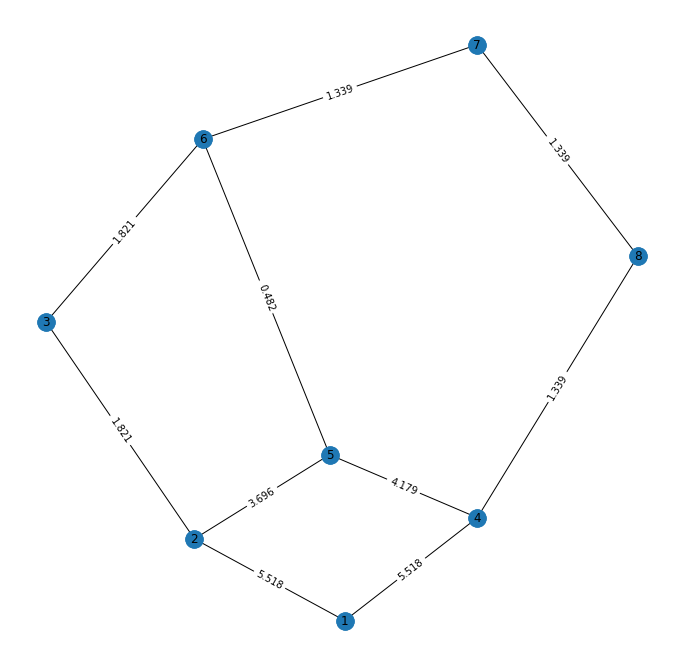

In [3034]:
NG2 = addCurrent(G,Iw)
draw(NG2)

***
* **f) Przedstaw (wizualizacja + sprawdzenie poprawnosci wyników) działanie programu dla grafów spójnych majacych od 15 do 100 wierzchołków:**
***
  1. **Spójny graf losowy**
***

In [3035]:
from random import randint

In [3036]:
def addToTable(G1):
    graph = []
    eds=G1.edges()
    idi = randint(1, n-1)
    ele=0
    dele=0
    for edge in G1.edges():
        ed = [0,0,0]
        weight = randint(3, 10)
        ed[2]=weight
        ed[0]=edge[0]
        ed[1]=edge[1]
        graph.append(ed)
        G1[edge[0]][edge[1]]['weight']=weight
        if idi==0:
            ele=edge[0]
            dele=edge[1]
        idi -=1
    
    ed=[ele,dele, randint(10,n+20)]
    graph.append(ed)
    return graph

def makeGraph1(n):
    G1=nx.Graph() 
    G1=nx.fast_gnp_random_graph(n,0.5)
    while nx.is_connected(G1)!=True:
        G1=nx.fast_gnp_random_graph(n,0.7)

    return G1


Ta funkcja tworzy spójny graf, składający się z n wierzchołków.

Następnie wykonuję kolejne działania, które doprowadzą mnie do rozwiązania.

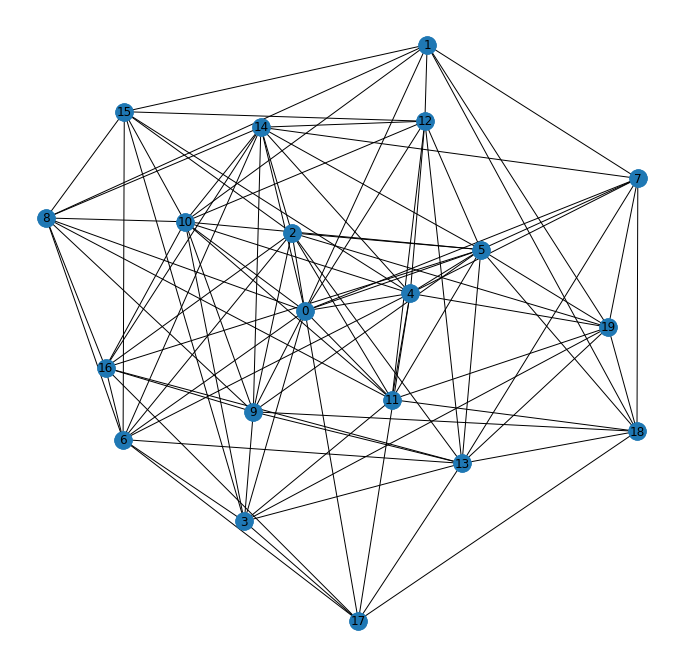

[1.01247826e-02 4.18078756e-03 1.69176290e-03 1.94274887e-03
 1.22804780e-03 6.90454159e-04 3.04324804e-03 1.88633862e-03
 3.64130697e-04 2.00094275e-03 9.58321093e-04 1.39691978e-03
 5.35866247e-04 7.73616438e-04 1.10377571e-02 1.36555444e-02
 1.58741664e-02 1.36657353e-02 1.30560344e-02 2.38675408e-02
 1.01281561e-01 6.57671352e-04 8.39963773e-04 9.26518641e-04
 9.79368213e-04 6.64119133e-04 2.75181090e-03 3.19970696e-03
 9.91518118e-04 1.51914646e-02 1.53992307e-03 8.56516403e-04
 2.97419476e-03 8.04362618e-04 2.17383795e-04 2.16979263e-03
 6.97113195e-04 1.09510494e-02 1.02005288e-03 8.34863140e-04
 3.60964154e-04 2.52276021e-03 3.36844820e-04 2.46345319e-03
 7.36956323e-04 3.58534654e-03 1.56464842e-03 1.53686385e-02
 8.89015931e-05 1.06383166e-03 2.91983257e-03 5.71105245e-06
 2.02628767e-03 1.61193947e-04 1.07735115e-03 4.42901870e-04
 2.05342827e-03 8.87815015e-03 3.26724694e-03 1.91438707e-03
 2.40341709e-05 1.55536789e-03 7.79154650e-05 2.81982299e-04
 7.56142021e-05 4.842814

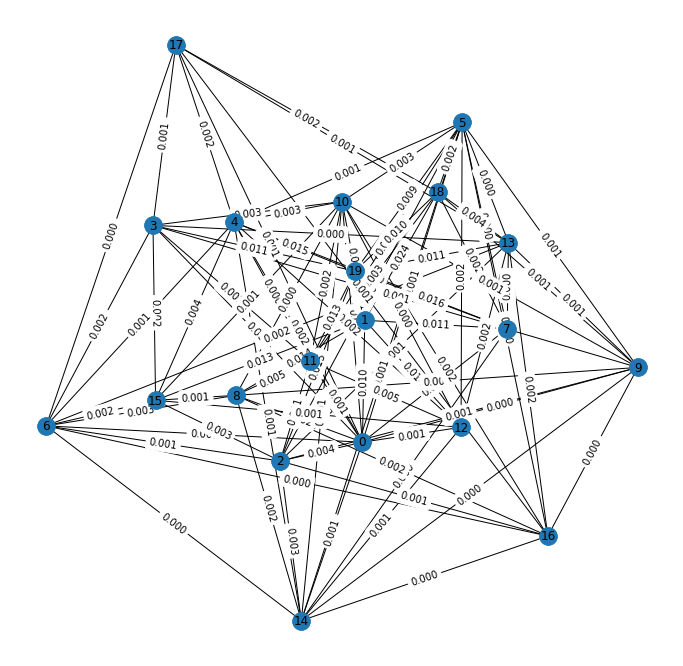

[1.01247826e-02 4.18078756e-03 1.69176290e-03 1.94274887e-03
 1.22804780e-03 6.90454159e-04 3.04324804e-03 1.88633862e-03
 3.64130697e-04 2.00094275e-03 9.58321093e-04 1.39691978e-03
 5.35866247e-04 7.73616438e-04 1.10377571e-02 1.36555444e-02
 1.58741664e-02 1.36657353e-02 1.30560344e-02 2.38675408e-02
 1.01281561e-01 6.57671352e-04 8.39963773e-04 9.26518641e-04
 9.79368213e-04 6.64119133e-04 2.75181090e-03 3.19970696e-03
 9.91518118e-04 1.51914646e-02 1.53992307e-03 8.56516403e-04
 2.97419476e-03 8.04362618e-04 2.17383795e-04 2.16979263e-03
 6.97113195e-04 1.09510494e-02 1.02005288e-03 8.34863140e-04
 3.60964154e-04 2.52276021e-03 3.36844820e-04 2.46345319e-03
 7.36956323e-04 3.58534654e-03 1.56464842e-03 1.53686385e-02
 8.89015931e-05 1.06383166e-03 2.91983257e-03 5.71105245e-06
 2.02628767e-03 1.61193947e-04 1.07735115e-03 4.42901870e-04
 2.05342827e-03 8.87815015e-03 3.26724694e-03 1.91438707e-03
 2.40341709e-05 1.55536789e-03 7.79154650e-05 2.81982299e-04
 7.56142021e-05 4.842814

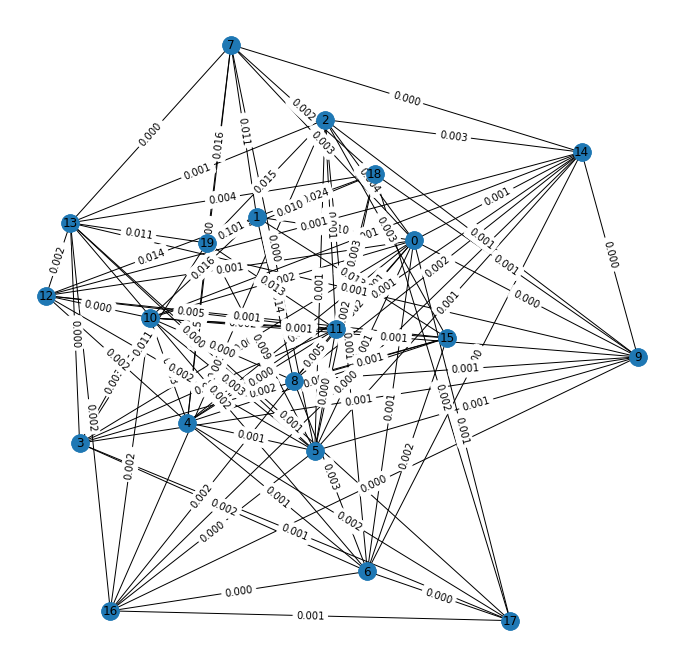

Wyniki są równe -  True


In [3037]:
G = makeGraph1(20)
draw(G)
graph=addToTable(G)
last=graph[len(G.nodes())]


B=makeB(G)
Z=makeZ(G)
E=makeE(graph,G)
Io = solve(B,E,Z)
print(Io)
C =addCurrent(G,Io)
draw(C)

Aa=makeA(G)
A=chooseReferenceA(Aa,0)
Gd=makeGd(G)
Gc=makeGc(A,Gd)
U=makeU(Gc,A,Gd,E)
Iw = abs(getThisResultsArg(U,Gd))
print(Iw)
C2 =addCurrent(G,Iw)
draw(C2)

print("Wyniki są równe - ",np.allclose(Iw,Io))

   2. **Graf 3-regularny (kubiczny)**

In [3038]:
def makeGraph2(n):
    G=nx.Graph() 
    G=nx.random_regular_graph(3,n)
    return G

[1.66838307e-02 1.90212029e-02 2.33737219e-03 1.48658745e-02
 3.15497052e-02 1.71788971e-02 1.76744422e-02 4.95545108e-04
 1.43708081e-02 1.00197741e-05 2.30936050e-05 3.31133791e-05
 6.86083054e-06 3.15894356e-06 6.58579675e-03 2.04652989e-04
 6.38114376e-03 6.11424521e-03 1.27000420e-02 1.38752630e-02
 3.15497052e-02 1.88496633e-02 3.25766055e-06 6.76211356e-06
 1.00197741e-05 9.87169862e-08 1.71539610e-04 1.25285024e-02
 6.14735859e-03 3.31133791e-05]


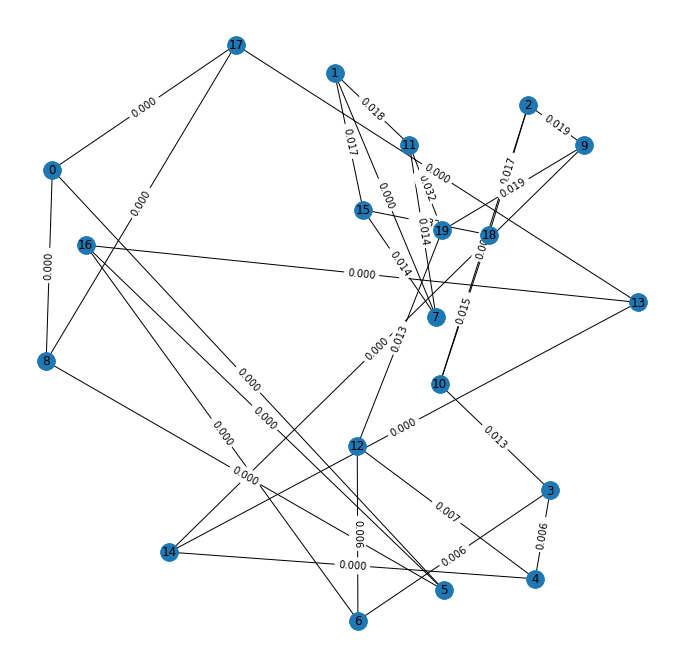

[1.66838307e-02 1.90212029e-02 2.33737219e-03 1.48658745e-02
 3.15497052e-02 1.71788971e-02 1.76744422e-02 4.95545108e-04
 1.43708081e-02 1.00197741e-05 2.30936050e-05 3.31133791e-05
 6.86083054e-06 3.15894356e-06 6.58579675e-03 2.04652989e-04
 6.38114376e-03 6.11424521e-03 1.27000420e-02 1.38752630e-02
 3.15497052e-02 1.88496633e-02 3.25766055e-06 6.76211356e-06
 1.00197741e-05 9.87169862e-08 1.71539610e-04 1.25285024e-02
 6.14735859e-03 3.31133791e-05]


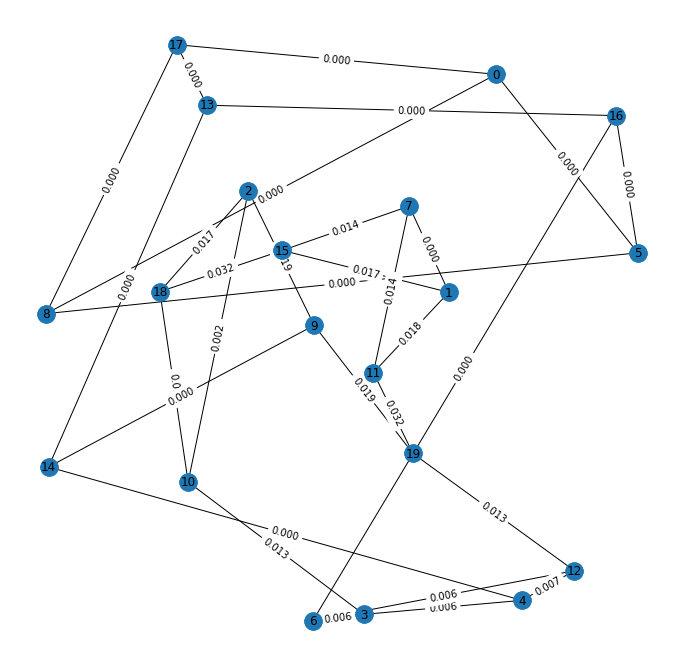

Wyniki są równe -  True


In [3039]:
G = makeGraph2(20)
graph=addToTable(G)
last=graph[len(G.nodes())]

B=makeB(G)
Z=makeZ(G)
E=makeE(graph,G)
Io = solve(B,E,Z)
print(Io)
C =addCurrent(G,Io)
draw(C)

Aa=makeA(G)
A=chooseReferenceA(Aa,0)
Gd=makeGd(G)
Gc=makeGc(A,Gd)
U=makeU(Gc,A,Gd,E)
Iw = abs(getThisResultsArg(U,Gd))
print(Iw)
C2 =addCurrent(G,Iw)
draw(C2)

print("Wyniki są równe - ",np.allclose(Iw,Io))

   3. **Graf złozony z dwóch grafów losowych połaczonych mostkiem**

In [3040]:
def makeGraph3(n):
    i =int((n/2)-1);
    g1=makeGraph1(i)
    g2=makeGraph1(int(n-i))
    G=nx.Graph()
    G.add_nodes_from(g1.nodes())
    G.add_edges_from(g1.edges())
    nodes2=[]
    idi = randint(0,i-1)
    node1=0
    for node in g2.nodes():
        node+=i
        nodes2.append(node)
        if idi==0:
            node1=node
        idi-=1
    G.add_nodes_from(nodes2)
    edges2=[]
    for edge in g2.edges():
        edges2.append((edge[0]+i, edge[1]+i))
    edges2.append((0,node1))
    G.add_edges_from(edges2)
    return G

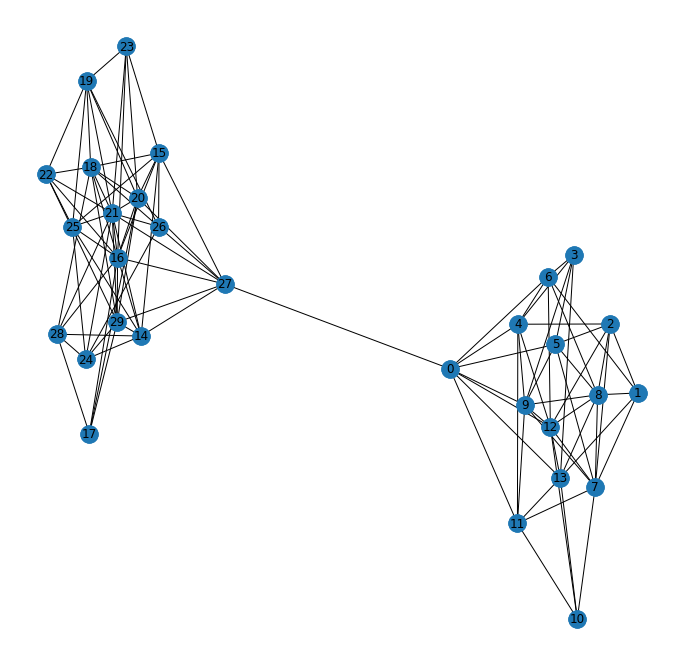

[0.06777941 0.5655686  0.07812203 0.08507163 0.09539164 0.12297401
 0.11622989 0.         0.02326139 0.01046302 0.00642803 0.00663623
 0.02586263 0.01898951 0.08590161 0.00600617 0.00998893 0.02765561
 0.03882665 0.15162703 0.04452794 0.03336221 0.03491023 0.00065985
 0.02305629 0.00815964 0.00559325 0.10078505 0.09988576 0.12736914
 0.04211031 0.01831939 0.00080936 0.00154815 0.0152674  0.06271111
 0.02474221 0.00147757 0.02014323 0.04165312 0.02262387 0.02695385
 0.00590989 0.00342025 0.00593725 0.00401288 0.00385378 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.


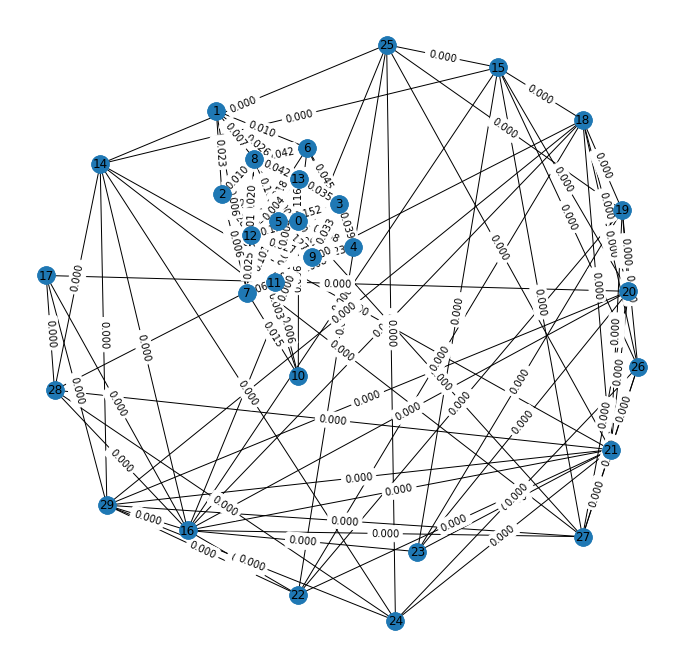

[0.06777941 0.5655686  0.07812203 0.08507163 0.09539164 0.12297401
 0.11622989 0.         0.02326139 0.01046302 0.00642803 0.00663623
 0.02586263 0.01898951 0.08590161 0.00600617 0.00998893 0.02765561
 0.03882665 0.15162703 0.04452794 0.03336221 0.03491023 0.00065985
 0.02305629 0.00815964 0.00559325 0.10078505 0.09988576 0.12736914
 0.04211031 0.01831939 0.00080936 0.00154815 0.0152674  0.06271111
 0.02474221 0.00147757 0.02014323 0.04165312 0.02262387 0.02695385
 0.00590989 0.00342025 0.00593725 0.00401288 0.00385378 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.


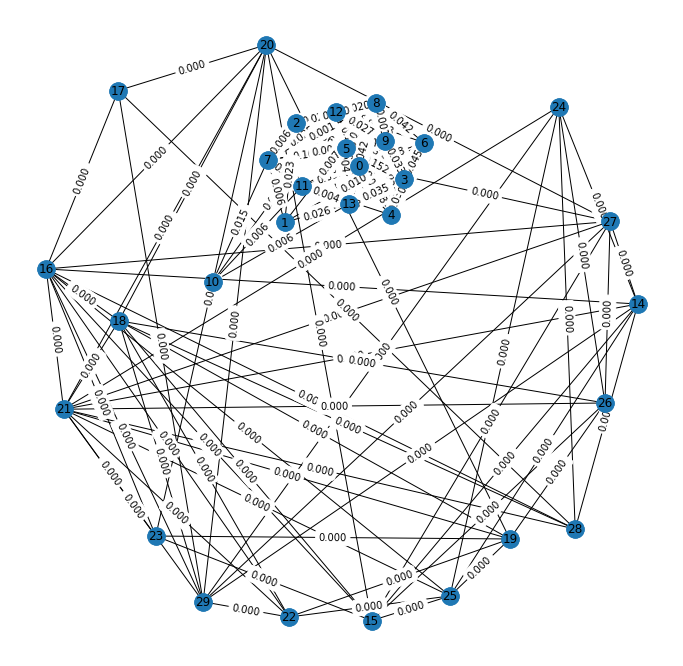

Wyniki są równe -  True


In [3041]:
G = makeGraph3(30)
draw(G)
graph=addToTable(G)
last=graph[len(graph)-1]

B=makeB(G)
Z=makeZ(G)
E=makeE(graph,G)
Io = solve(B,E,Z)
print(Io)
C =addCurrent(G,Io)
draw(C)

Aa=makeA(G)
A=chooseReferenceA(Aa,0)
Gd=makeGd(G)
Gc=makeGc(A,Gd)
U=makeU(Gc,A,Gd,E)
Iw = abs(getThisResultsArg(U,Gd))
print(Iw)
C2 =addCurrent(G,Iw)
draw(C2)

print("Wyniki są równe - ",np.allclose(Iw,Io))

Macierz prądów jest zgodna z przewidywaniami, ponieważ graf z mostem nie jest obwodem - nie ma możliwości żeby przez obie "strony" złączone mostem płynął prąd. Jeśli więc ten z obwodów, do którego gałęzi przyłączone jest napięcie będzie poprawny, to w tym obwodzie popłynie prąd. W gałęziach należących do obwodu "po drugiej stronie mostu" będzie wtedy prąd równy 0.

   4. **Graf siatka 2D**

In [3042]:
def makeGraph4(n,m):
    G=nx.Graph() 
    G=nx.grid_2d_graph(n,m)
    return G

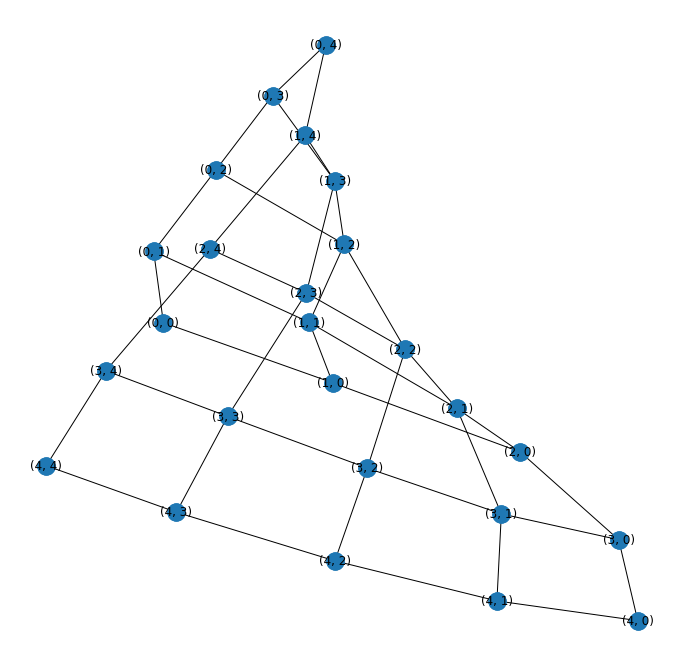

[0.06690631 0.06690631 0.09332484 0.16023115 0.07641619 0.08381496
 0.06999493 0.01382003 0.01382003 0.03273421 0.0341721  0.03059593
 0.09690102 0.01723452 0.03771934 0.0287105  0.00356509 0.01738512
 0.01507705 0.01765716 0.01225357 0.03599951 0.00307184 0.02183683
 0.01199599 0.00512232 0.0122628  0.00683889 0.00823816 0.00408758
 0.01640415 0.00149539 0.01183693 0.00552234 0.00536328 0.00689952
 0.00683889 0.01092647 0.01242186 0.00689952]


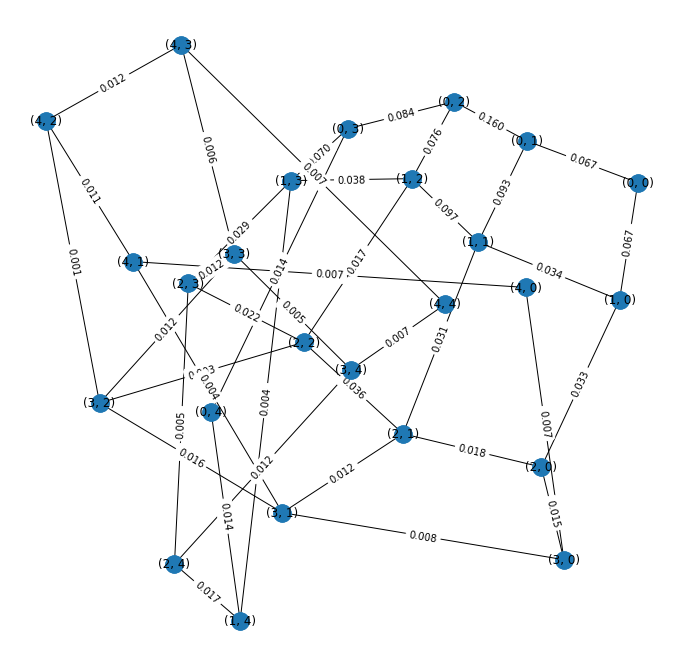

[0.06690631 0.06690631 0.09332484 0.16023115 0.07641619 0.08381496
 0.06999493 0.01382003 0.01382003 0.03273421 0.0341721  0.03059593
 0.09690102 0.01723452 0.03771934 0.0287105  0.00356509 0.01738512
 0.01507705 0.01765716 0.01225357 0.03599951 0.00307184 0.02183683
 0.01199599 0.00512232 0.0122628  0.00683889 0.00823816 0.00408758
 0.01640415 0.00149539 0.01183693 0.00552234 0.00536328 0.00689952
 0.00683889 0.01092647 0.01242186 0.00689952]


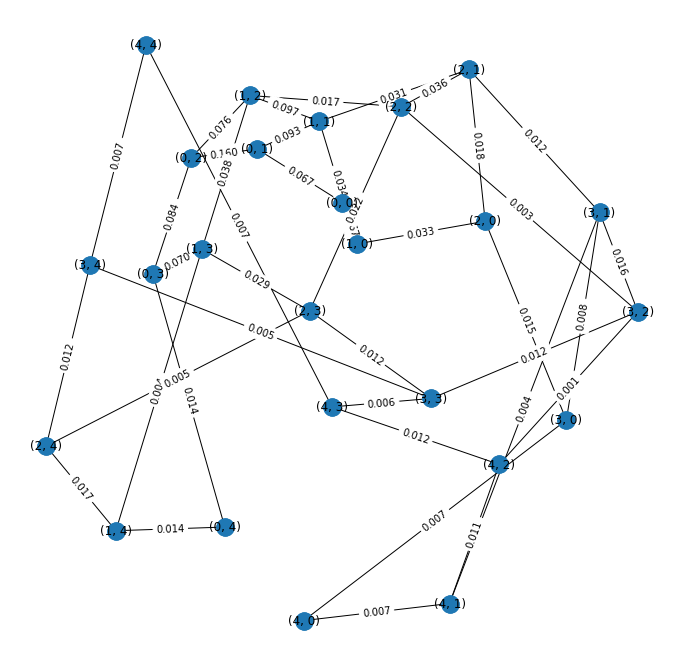

Wyniki są równe -  True


In [3043]:
G = makeGraph4(5,5)
draw(G)
graph=addToTable(G)
last=graph[len(graph)-1]

B=makeB(G)
Z=makeZ(G)
E=makeE(graph,G)
Io = solve(B,E,Z)
print(Io)
C =addCurrent(G,Io)
draw(C)

Aa=makeA(G)
A=chooseReferenceA(Aa,0)
Gd=makeGd(G)
Gc=makeGc(A,Gd)
U=makeU(Gc,A,Gd,E)
Iw = abs(getThisResultsArg(U,Gd))
print(Iw)
C2 =addCurrent(G,Iw)
draw(C2)

print("Wyniki są równe - ",np.allclose(Iw,Io))

***
**Wnioski**<br><br>
Dla wszytskich utworzonych grafów prądy gałęziowe wyliczone przy użyciu metody oczkowej są równe prądom gałęziowym wyliczonym przy pomocy metody węzłowej. Zatem obie metody są równie dobre. W metodzie oczkowej głównym zadanem jest wyznaczenie oczek (II prawo Kirchoffa), z których później tworzy się macierz B, podczas gdy w metoda węzłowa opiera się na wyznaczeniu, które prądy wpływają, a które wypływają z każdego węzła.